Conservative PSN (Parametric Spectral Network) Multi-Dataset Training
Real/Imag + Hamming + Freq Clamp - Original Architecture Preserved
Device: cuda

Hyperparameters:
  Frequency LR: 0.0001
  Other LR: 0.001
  Epochs: 50
Loading All Datasets

############################################################
Loading UCI-HAR...
############################################################
Train: (7352, 128, 9) | Classes: 6
Test: (2947, 128, 9) | Classes: 6
Activity Names: ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
Train class distribution: {np.int64(0): 1226, np.int64(1): 1073, np.int64(2): 986, np.int64(3): 1286, np.int64(4): 1374, np.int64(5): 1407}
Test class distribution: {np.int64(0): 496, np.int64(1): 471, np.int64(2): 420, np.int64(3): 491, np.int64(4): 532, np.int64(5): 537}

############################################################
Loading WISDM...
############################################################
Train: (19030, 80, 3) | Class

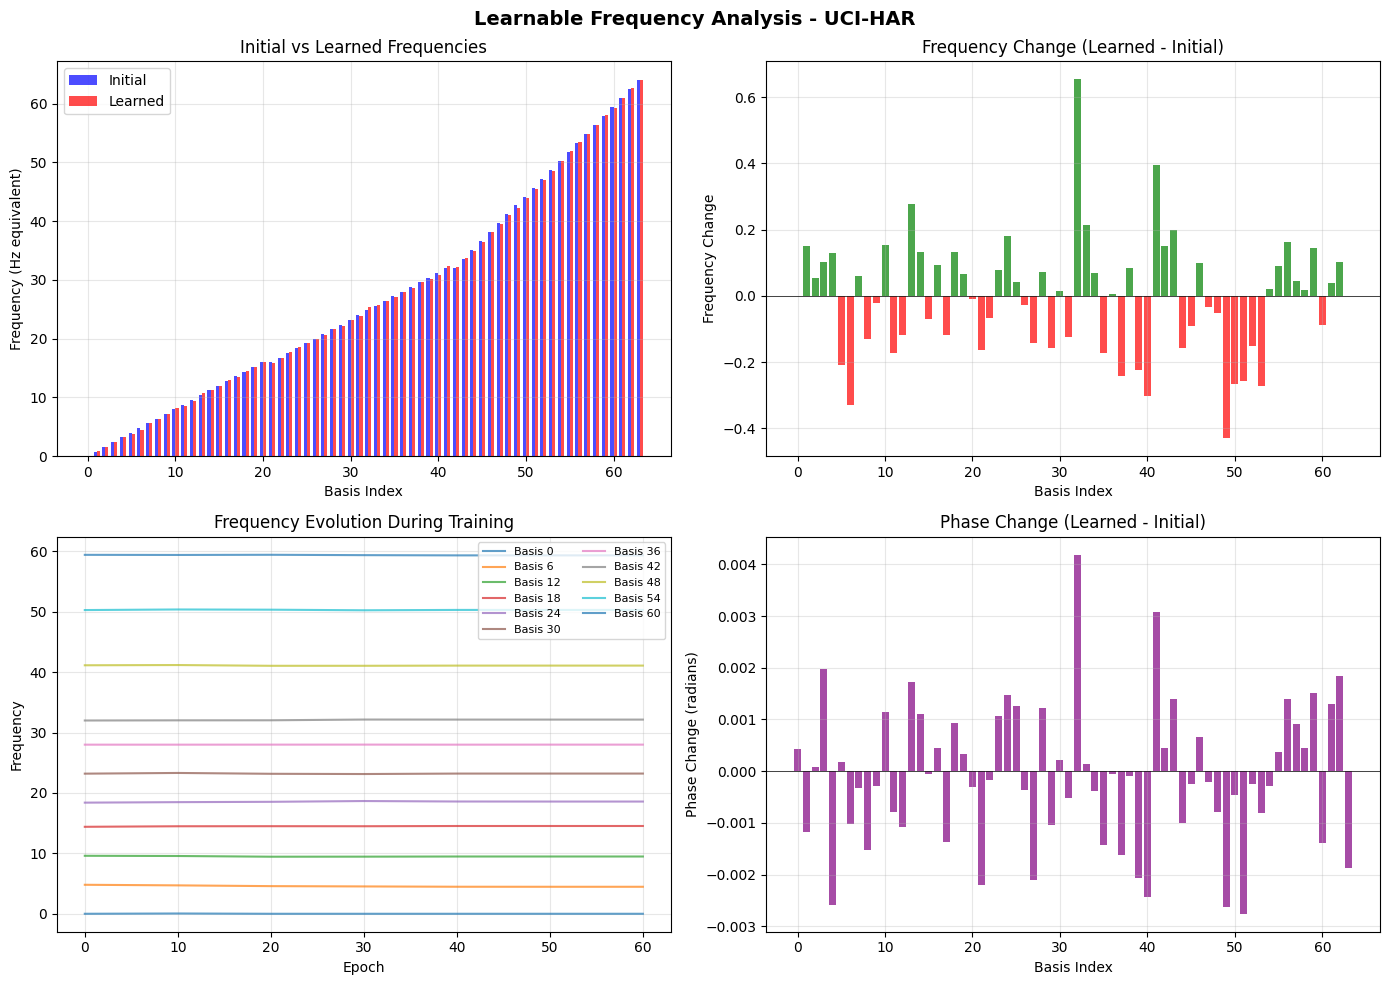


  Frequency Learning Statistics for UCI-HAR:
    Mean absolute frequency change: 0.1378
    Max frequency change: 0.6536
    Std of frequency change: 0.1789
    % frequencies that increased: 51.6%
    % frequencies that decreased: 45.3%

ABLATION STUDY - WISDM
Frequency LR: 0.0001, Other LR: 0.001

--- Full Model ---
  Acc: 0.9903 | F1: 0.9856 | Params: 0.57M | FLOPs: 31.54M | Inf: 4.39ms | Delta: -

--- w/o Spectral Path ---
  Acc: 0.9920 | F1: 0.9883 | Params: 0.26M | FLOPs: 30.06M | Inf: 1.15ms | Delta: 0.2%

--- w/o Temporal Path ---
  Acc: 0.9191 | F1: 0.8865 | Params: 0.22M | FLOPs: 0.96M | Inf: 2.02ms | Delta: -7.1%

--- Fixed Frequencies ---
  Acc: 0.9904 | F1: 0.9861 | Params: 0.57M | FLOPs: 31.54M | Inf: 4.16ms | Delta: 0.0%

--- Magnitude Only ---
  Acc: 0.9906 | F1: 0.9864 | Params: 0.46M | FLOPs: 30.93M | Inf: 5.88ms | Delta: 0.0%

--- Simple Concatenation ---
  Acc: 0.9895 | F1: 0.9844 | Params: 0.44M | FLOPs: 30.95M | Inf: 3.22ms | Delta: -0.1%

--- Simple Summation ---

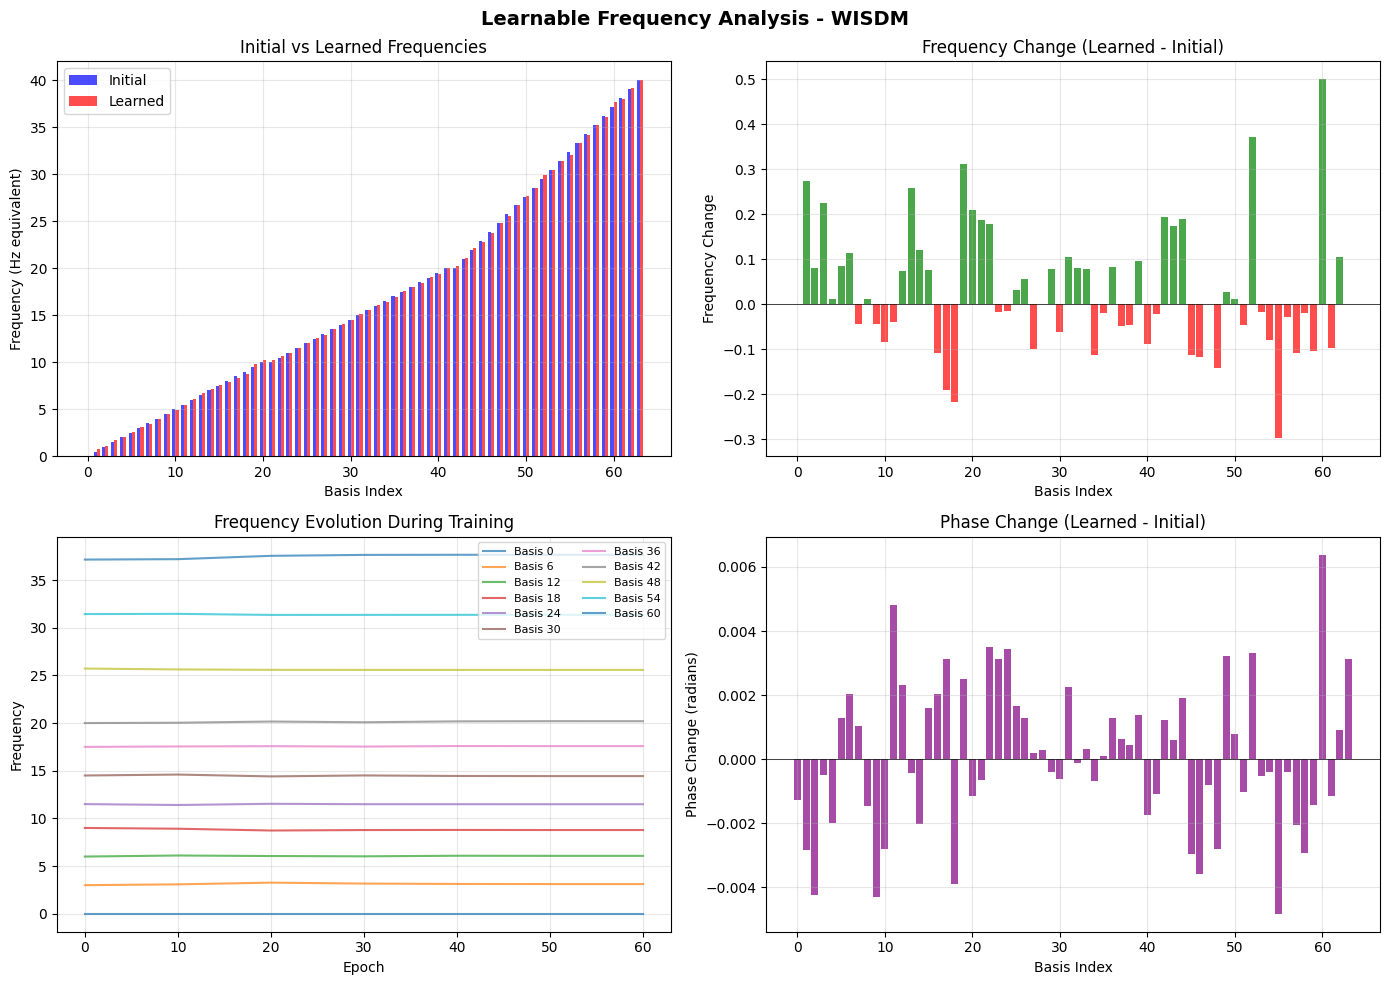


  Frequency Learning Statistics for WISDM:
    Mean absolute frequency change: 0.1067
    Max frequency change: 0.4996
    Std of frequency change: 0.1409
    % frequencies that increased: 50.0%
    % frequencies that decreased: 46.9%

ABLATION STUDY - MotionSense
Frequency LR: 0.0001, Other LR: 0.001

--- Full Model ---
  Acc: 0.9690 | F1: 0.9463 | Params: 0.81M | FLOPs: 44.48M | Inf: 43.14ms | Delta: -

--- w/o Spectral Path ---
  Acc: 0.9625 | F1: 0.9400 | Params: 0.50M | FLOPs: 10.38M | Inf: 1.22ms | Delta: -0.6%

--- w/o Temporal Path ---
  Acc: 0.9661 | F1: 0.9417 | Params: 0.22M | FLOPs: 33.85M | Inf: 40.98ms | Delta: -0.3%

--- Fixed Frequencies ---


KeyboardInterrupt: 

In [1]:
!pip install thop ptflops
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from thop import profile
from collections import Counter
from glob import glob
import time
import os
import math

def clean_state_dict(state_dict):
    return {k: v for k, v in state_dict.items()
            if 'total_ops' not in k and 'total_params' not in k}

class UCIHARDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def read_txt_matrix(file_path):
    return np.loadtxt(file_path)


def load_uci_har(root_path='/content/drive/MyDrive/HAR_Dataset/UCI'):
    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    def load_split(split):
        channels = []
        for prefix in UCI_CHANNELS_PREFIX:
            file_path = os.path.join(root_path, f"{prefix}{split}.txt")
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")
            channels.append(read_txt_matrix(file_path))
        X = np.stack(channels, axis=1)
        y = read_txt_matrix(os.path.join(root_path, f"y_{split}.txt")).astype(int) - 1
        return X, y
    X_train, y_train = load_split('train')
    X_test, y_test = load_split('test')
    X_train = X_train.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    scaler = StandardScaler()
    scaler.fit(X_train_flat)
    X_train_flat = scaler.transform(X_train_flat)
    X_test_flat = scaler.transform(X_test_flat)
    X_train = X_train_flat.reshape(X_train.shape)
    X_test = X_test_flat.reshape(X_test.shape)
    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    return X_train, y_train.astype(np.int64), X_test, y_test.astype(np.int64), activity_names


def load_wisdm_data(dataset_path="/content/drive/MyDrive/HAR_Dataset/WISDM"):
    if os.path.isfile(dataset_path):
        file_paths = [dataset_path]
    else:
        possible_files = ['WISDM_ar_v1.1_raw.txt', 'WISDM_ar_v1.1_trans.arff', 'wisdm-dataset.txt', 'actitracker_raw.txt']
        file_paths = []
        for filename in possible_files:
            full_path = os.path.join(dataset_path, filename)
            if os.path.exists(full_path):
                file_paths.append(full_path)
    if not file_paths:
        return None, None, None, None, None
    all_data = []
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        cleaned_data = []
        for line in lines:
            line = line.strip()
            if not line:
                continue
            line = line.rstrip(';').rstrip(',')
            if ',' in line:
                parts = line.split(',')
            elif ';' in line:
                parts = line.split(';')
            else:
                continue
            if len(parts) < 6:
                continue
            try:
                user = parts[0].strip()
                activity = parts[1].strip()
                timestamp = parts[2].strip()
                x_str = parts[3].strip()
                y_str = parts[4].strip()
                z_str = parts[5].strip()
                if ';' in x_str:
                    x_str = x_str.split(';')[0]
                if ';' in y_str:
                    y_str = y_str.split(';')[0]
                if ';' in z_str:
                    z_str = z_str.split(';')[0]
                x = float(x_str)
                y = float(y_str)
                z = float(z_str)
                cleaned_data.append([user, activity, timestamp, x, y, z])
            except (ValueError, IndexError):
                continue
        if cleaned_data:
            df = pd.DataFrame(cleaned_data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
            df['x'] = pd.to_numeric(df['x'], errors='coerce')
            df['y'] = pd.to_numeric(df['y'], errors='coerce')
            df['z'] = pd.to_numeric(df['z'], errors='coerce')
            df = df.dropna()
            all_data.append(df)
    if not all_data:
        return None, None, None, None, None
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df = combined_df.dropna()
    combined_df = combined_df[combined_df['activity'].str.strip() != '']
    all_windows = []
    all_labels = []
    groups = combined_df.groupby(['user', 'activity']) if 'user' in combined_df.columns else combined_df.groupby(['activity'])
    window_size = 80
    step = 40
    for group_name, group_data in groups:
        activity = group_name[-1] if isinstance(group_name, tuple) else group_name
        acc_data = group_data[['x', 'y', 'z']].values.astype(np.float32)
        if len(acc_data) < window_size:
            continue
        start = 0
        while start + window_size <= len(acc_data):
            window_data = acc_data[start:start + window_size, :]
            all_windows.append(window_data)
            all_labels.append(activity)
            start += step
    if not all_windows:
        return None, None, None, None, None
    X_windowed = np.array(all_windows, dtype=np.float32)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(all_labels)
    class_names = [str(label) for label in label_encoder.classes_]
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, class_names


def load_dsads_data(data_path, w_s=25, stride=12):
    all_windows = []
    all_labels = []
    activities = {
        'a01': 'sitting', 'a02': 'standing', 'a03': 'lying on back',
        'a04': 'lying on right side', 'a05': 'ascending stairs',
        'a06': 'descending stairs', 'a07': 'standing in an elevator still',
        'a08': 'moving around in an elevator', 'a09': 'walking in a parking lot',
        'a10': 'walking on a treadmill with a speed of 4 kmh',
        'a11': 'walking in flat and 15 deg inclined positions',
        'a12': 'running on a treadmill with a speed of 8 kmh',
        'a13': 'exercising on a stepper', 'a14': 'exercising on a cross trainer',
        'a15': 'cycling on an exercise bike in horizontal positions',
        'a16': 'cycling on an exercise bike in vertical positions',
        'a17': 'rowing', 'a18': 'jumping', 'a19': 'playing basketball'
    }
    activity_codes = sorted(activities.keys())
    label_encoder = LabelEncoder()
    label_encoder.fit(activity_codes)
    persons = ['p' + str(i) for i in range(1, 9)]
    for person_str in persons:
        for activity_str in activity_codes:
            activity_label = label_encoder.transform([activity_str])[0]
            pattern = os.path.join(data_path, activity_str, person_str, 's*.txt')
            segment_files = sorted(glob(pattern))
            if not segment_files:
                continue
            for f in segment_files[:11]:
                try:
                    segment_data = np.loadtxt(f, delimiter=',')
                    if segment_data.shape[0] < w_s or segment_data.shape[1] < 45:
                        continue
                    segment_data = np.nan_to_num(segment_data, nan=0.0)
                    start = 0
                    while start + w_s <= segment_data.shape[0]:
                        window_data = segment_data[start : start + w_s, :]
                        all_windows.append(window_data)
                        all_labels.append(activity_label)
                        start += stride
                except:
                    continue
    if not all_windows:
        return None, None, None, None, None
    X_windowed = np.array(all_windows, dtype=np.float32)
    y_encoded = np.array(all_labels, dtype=int)
    scaler = StandardScaler()
    X_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_flat = scaler.fit_transform(X_flat)
    X_windowed = X_flat.reshape(X_windowed.shape)
    activity_names_sorted = [activities[code] for code in label_encoder.classes_]
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_names_sorted


def load_pamap2_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/PAMAP2"):
    file_paths = sorted(glob(os.path.join(dataset_dir, 'Protocol', 'subject*.dat')))
    optional_path = os.path.join(dataset_dir, 'Optional')
    if os.path.exists(optional_path):
        file_paths += sorted(glob(os.path.join(optional_path, 'subject*.dat')))
    if not file_paths:
        return None, None, None, None, None
    activity_labels = [
        "lying", "sitting", "standing", "walking", "running", "cycling",
        "Nordic walking", "ascending stairs", "descending stairs",
        "vacuum cleaning", "ironing", "rope jumping"
    ]
    label_to_activity_idx = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }
    all_windows = []
    all_labels = []
    window_size = 100
    step = 50
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=r'\s+', header=None, na_values='NaN')
        except:
            continue
        df_cleaned = df.ffill().bfill()
        if df_cleaned.empty:
            continue
        labels = df_cleaned.iloc[:, 1].values.astype(int)
        all_sensor_cols = list(range(4, 10)) + list(range(21, 27)) + list(range(38, 44))
        if df_cleaned.shape[1] < max(all_sensor_cols) + 1:
            continue
        features = df_cleaned.iloc[:, all_sensor_cols].values.astype(np.float32)
        valid_indices = np.where(np.isin(labels, list(label_to_activity_idx.keys())))[0]
        if len(valid_indices) == 0:
            continue
        features = features[valid_indices, :]
        labels = labels[valid_indices]
        if len(features) < window_size:
            continue
        start = 0
        while start + window_size <= len(features):
            window_data = features[start : start + window_size, :]
            window_labels_raw = labels[start : start + window_size]
            most_common_label = Counter(window_labels_raw).most_common(1)[0][0]
            if most_common_label in label_to_activity_idx:
                all_windows.append(window_data)
                all_labels.append(label_to_activity_idx[most_common_label])
            start += step
    if not all_windows:
        return None, None, None, None, None
    X_windowed = np.array(all_windows, dtype=np.float32)
    y_encoded = np.array(all_labels, dtype=int)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_labels


def load_mhealth_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/MHEALTH"):
    if not os.path.exists(dataset_dir):
        return None, None, None, None, None
    subject_files = sorted([
        os.path.join(dataset_dir, f)
        for f in os.listdir(dataset_dir)
        if f.startswith("mHealth_subject") and f.endswith(".log")
    ])
    if not subject_files:
        return None, None, None, None, None
    all_windows = []
    all_labels = []
    window_size = 50
    step = 25
    for file_path in subject_files:
        try:
            df = pd.read_csv(file_path, sep=r'\s+', header=None, engine='python', dtype=np.float32)
            df = df.ffill().bfill()
            if df.shape[1] < 24:
                continue
            labels = df.iloc[:, 23].values.astype(int)
            imu_cols = [0, 1, 2] + list(range(5, 23))
            features = df.iloc[:, imu_cols].values
            valid_indices = np.where(labels != 0)[0]
            if len(valid_indices) == 0:
                continue
            features = features[valid_indices, :]
            labels = labels[valid_indices]
            if len(features) < window_size:
                continue
            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]
                window_labels_raw = labels[start : start + window_size]
                most_common_label = Counter(window_labels_raw).most_common(1)[0][0]
                all_windows.append(window_data)
                all_labels.append(most_common_label)
                start += step
        except:
            continue
    if not all_windows:
        return None, None, None, None, None
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(all_labels)
    X_windowed = np.array(all_windows, dtype=np.float32)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    mhealth_activity_mapping = {
        1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down', 4: 'Walking',
        5: 'Climbing stairs', 6: 'Waist bends forward', 7: 'Frontal elevation of arms',
        8: 'Knees bending', 9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
    }
    activity_labels = []
    class_names = list(label_encoder.classes_)
    for encoded_idx in range(len(class_names)):
        original_label = class_names[encoded_idx]
        activity_labels.append(mhealth_activity_mapping.get(original_label, f"Unknown_Activity_{original_label}"))
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_labels


class MotionSenseLoader:
    def __init__(self, frame_len, feature_name, N_classes):
        self.feature_names = feature_name
        self.N_Feature = len(feature_name)
        self.frame_length = frame_len
        self.hop_size = frame_len//2
        self.N_classes = N_classes
        self.label_encoder = OneHotEncoder(sparse_output=False)
    def framing(self, signal):
        shape = ((signal.shape[0] - self.frame_length) // self.hop_size + 1, self.frame_length)
        strides = (signal.strides[0] * self.hop_size, signal.strides[0])
        return np.lib.stride_tricks.as_strided(signal, shape=shape, strides=strides)
    def create_label(self, label): return self.label_encoder.fit_transform(label)
    def load_trainings_data(self, files, label_frame):
        label = self.create_label(label_frame)
        self.trainings_data, self.trainings_label = self.load_data(files, label)
    def load_validation_data(self, files, label_frame):
        label = self.label_encoder.transform(label_frame)
        self.validation_data, self.validation_label = self.load_data(files, label)
    def load_data(self, files, label):
        feature_matrix, label_matrix = None, None
        for i in range(len(files)):
            try: tmp_data = pd.read_csv(files[i], engine='python')
            except: continue
            N_Blocks = 1+(np.shape(tmp_data)[0]-self.frame_length)//self.hop_size
            if N_Blocks <= 0: continue
            tmp_feature_mat = np.zeros((N_Blocks, self.frame_length, self.N_Feature))
            tmp_label_vec = np.zeros((N_Blocks, self.N_classes))
            for j in range(N_Blocks): tmp_label_vec[j, :] = label[i, :]
            for idf, feat in enumerate(self.feature_names):
                frame_matrix = self.framing(tmp_data[feat].to_numpy())
                tmp_feature_mat[:, :, idf] = frame_matrix[:N_Blocks]
            if feature_matrix is None:
                feature_matrix = tmp_feature_mat
                label_matrix = tmp_label_vec
            else:
                feature_matrix = np.append(feature_matrix, tmp_feature_mat, axis=0)
                label_matrix = np.append(label_matrix, tmp_label_vec, axis=0)
        return feature_matrix, label_matrix

def load_motionsense_data(root_path='/content/drive/MyDrive/HAR_Dataset/MOTIONSENSE'):
    files, label = [], []
    for dirname, _, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith('.csv') and not filename.startswith('.'):
                full_path = os.path.join(dirname, filename)
                if 'sub_' in filename:
                    files.append(full_path)
                    parent_dir = os.path.basename(os.path.dirname(full_path))
                    if '_' in parent_dir: label.append(parent_dir.split('_')[0])
                    else: files.pop()
    if not files: return None, None, None, None, None
    label_frame = pd.DataFrame(label, columns=['act'])
    files_train, files_valid, y_train_raw, y_valid_raw = train_test_split(files, label_frame, test_size=0.2, random_state=0)
    Feature = ['attitude.roll','attitude.pitch','attitude.yaw','gravity.x','gravity.y','gravity.z',
               'rotationRate.x','rotationRate.y','rotationRate.z','userAcceleration.x','userAcceleration.y','userAcceleration.z']
    N_classes = 6
    loader = MotionSenseLoader(128, Feature, N_classes)
    loader.load_trainings_data(files_train, y_train_raw)
    loader.load_validation_data(files_valid, y_valid_raw)
    X_train = loader.trainings_data.astype(np.float32).transpose(0, 2, 1)
    X_test = loader.validation_data.astype(np.float32).transpose(0, 2, 1)
    y_train = np.argmax(loader.trainings_label, axis=1)
    y_test = np.argmax(loader.validation_label, axis=1)
    activity_names = list(loader.label_encoder.categories_[0])
    return X_train, y_train, X_test, y_test, activity_names


def load_unimib_shar_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/UNIMIB"):
    train_path = os.path.join(dataset_dir, "unimib_train.csv")
    test_path = os.path.join(dataset_dir, "unimib_test.csv")
    val_path = os.path.join(dataset_dir, "unimib_val.csv")
    if not os.path.exists(train_path): return None, None, None, None, None
    def process_unimib_csv(path):
        if not os.path.exists(path): return np.array([]), np.array([])
        df = pd.read_csv(path)
        df = df.sort_values(by=['ID', 't'])
        X_list, y_list = [], []
        for _, group in df.groupby('ID'):
            X_list.append(group[['ax', 'ay', 'az']].values.astype(np.float32))
            y_list.append(group['label'].iloc[0])
        return np.array(X_list), np.array(y_list)
    X_train, y_train_raw = process_unimib_csv(train_path)
    X_test, y_test_raw = process_unimib_csv(test_path)
    if os.path.exists(val_path):
        X_val, y_val_raw = process_unimib_csv(val_path)
        if len(X_val) > 0:
            X_test = np.concatenate((X_test, X_val), axis=0)
            y_test_raw = np.concatenate((y_test_raw, y_val_raw), axis=0)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train_raw)
    y_test = le.transform(y_test_raw)
    class_names = [str(c) for c in le.classes_]
    B_train, T, C = X_train.shape
    B_test, _, _ = X_test.shape
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(B_train, -1)).reshape(B_train, T, C).transpose(0, 2, 1)
    X_test = scaler.transform(X_test.reshape(B_test, -1)).reshape(B_test, T, C).transpose(0, 2, 1)
    return X_train, y_train, X_test, y_test, class_names


class ConservativeSpectralOperator(nn.Module):
    def __init__(self, seq_len, in_channels, num_basis=64):
        super().__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels
        self.num_basis = num_basis
        self.register_buffer('t', torch.arange(seq_len).float())

        hamming_window = torch.hamming_window(seq_len)
        self.register_buffer('hamming_window', hamming_window)

        low_band = num_basis // 3
        mid_band = num_basis // 3
        high_band = num_basis - low_band - mid_band
        freqs_low = torch.linspace(0, seq_len//8, low_band) / seq_len
        freqs_mid = torch.linspace(seq_len//8, seq_len//4, mid_band) / seq_len
        freqs_high = torch.linspace(seq_len//4, seq_len//2, high_band) / seq_len
        init_freqs = torch.cat([freqs_low, freqs_mid, freqs_high])
        self.frequencies = nn.Parameter(init_freqs)

        self.phases = nn.Parameter(torch.zeros(num_basis))
        self.channel_weights_real = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.channel_weights_imag = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.gamma = nn.Parameter(torch.ones(in_channels, num_basis * 2))
        self.beta = nn.Parameter(torch.zeros(in_channels, num_basis * 2))

    def forward(self, x):
        B, C, T = x.shape

        x = x * self.hamming_window.unsqueeze(0).unsqueeze(0)

        frequencies = torch.clamp(self.frequencies, 0.0, 0.5)

        args = 2 * np.pi * frequencies.unsqueeze(1) * self.t.unsqueeze(0) + self.phases.unsqueeze(1)
        basis_real = torch.cos(args)
        basis_imag = -torch.sin(args)

        spectral_real = torch.einsum('bct,ft->bcf', x, basis_real)
        spectral_imag = torch.einsum('bct,ft->bcf', x, basis_imag)

        weighted_real = spectral_real * (1 + self.channel_weights_real.unsqueeze(0)) - \
                       spectral_imag * self.channel_weights_imag.unsqueeze(0)
        weighted_imag = spectral_real * self.channel_weights_imag.unsqueeze(0) + \
                       spectral_imag * (1 + self.channel_weights_real.unsqueeze(0))

        spectral_features = torch.cat([weighted_real, weighted_imag], dim=-1)
        spectral_features = spectral_features / math.sqrt(self.seq_len)
        spectral_features = spectral_features * self.gamma.unsqueeze(0) + self.beta.unsqueeze(0)

        return spectral_features


class FixedSpectralOperator(nn.Module):
    def __init__(self, seq_len, in_channels, num_basis=64):
        super().__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels
        self.num_basis = num_basis
        self.register_buffer('t', torch.arange(seq_len).float())

        hamming_window = torch.hamming_window(seq_len)
        self.register_buffer('hamming_window', hamming_window)

        freqs = torch.linspace(0, seq_len//2, num_basis) / seq_len
        self.register_buffer('frequencies', freqs)
        self.register_buffer('phases', torch.zeros(num_basis))
        self.channel_weights_real = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.channel_weights_imag = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.gamma = nn.Parameter(torch.ones(in_channels, num_basis * 2))
        self.beta = nn.Parameter(torch.zeros(in_channels, num_basis * 2))

    def forward(self, x):
        B, C, T = x.shape

        x = x * self.hamming_window.unsqueeze(0).unsqueeze(0)

        args = 2 * np.pi * self.frequencies.unsqueeze(1) * self.t.unsqueeze(0) + self.phases.unsqueeze(1)
        basis_real = torch.cos(args)
        basis_imag = -torch.sin(args)

        spectral_real = torch.einsum('bct,ft->bcf', x, basis_real)
        spectral_imag = torch.einsum('bct,ft->bcf', x, basis_imag)

        weighted_real = spectral_real * (1 + self.channel_weights_real.unsqueeze(0)) - \
                       spectral_imag * self.channel_weights_imag.unsqueeze(0)
        weighted_imag = spectral_real * self.channel_weights_imag.unsqueeze(0) + \
                       spectral_imag * (1 + self.channel_weights_real.unsqueeze(0))

        spectral_features = torch.cat([weighted_real, weighted_imag], dim=-1)
        spectral_features = spectral_features / math.sqrt(self.seq_len)
        spectral_features = spectral_features * self.gamma.unsqueeze(0) + self.beta.unsqueeze(0)

        return spectral_features


class RealOnlySpectralOperator(nn.Module):
    def __init__(self, seq_len, in_channels, num_basis=64):
        super().__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels
        self.num_basis = num_basis
        self.register_buffer('t', torch.arange(seq_len).float())

        hamming_window = torch.hamming_window(seq_len)
        self.register_buffer('hamming_window', hamming_window)

        low_band = num_basis // 3
        mid_band = num_basis // 3
        high_band = num_basis - low_band - mid_band
        freqs_low = torch.linspace(0, seq_len//8, low_band) / seq_len
        freqs_mid = torch.linspace(seq_len//8, seq_len//4, mid_band) / seq_len
        freqs_high = torch.linspace(seq_len//4, seq_len//2, high_band) / seq_len
        init_freqs = torch.cat([freqs_low, freqs_mid, freqs_high])
        self.frequencies = nn.Parameter(init_freqs)
        self.phases = nn.Parameter(torch.zeros(num_basis))
        self.channel_weights_real = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.gamma = nn.Parameter(torch.ones(in_channels, 1))
        self.beta = nn.Parameter(torch.zeros(in_channels, 1))

    def forward(self, x):
        B, C, T = x.shape

        x = x * self.hamming_window.unsqueeze(0).unsqueeze(0)

        frequencies = torch.clamp(self.frequencies, 0.0, 0.5)

        args = 2 * np.pi * frequencies.unsqueeze(1) * self.t.unsqueeze(0) + self.phases.unsqueeze(1)
        basis_real = torch.cos(args)
        basis_imag = -torch.sin(args)

        spectral_real = torch.einsum('bct,ft->bcf', x, basis_real)
        spectral_imag = torch.einsum('bct,ft->bcf', x, basis_imag)

        weighted_real = spectral_real * (1 + self.channel_weights_real.unsqueeze(0))
        weighted_imag = spectral_imag * (1 + self.channel_weights_real.unsqueeze(0))

        spectral_mag = torch.sqrt(weighted_real**2 + weighted_imag**2 + 1e-8)
        spectral_mag = spectral_mag / math.sqrt(self.seq_len)
        spectral_mag = spectral_mag * self.gamma.unsqueeze(0) + self.beta.unsqueeze(0)
        return spectral_mag


class SpectralAttention(nn.Module):
    def __init__(self, num_basis, num_heads=2, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = num_basis // num_heads
        self.qkv = nn.Linear(num_basis, num_basis * 3)
        self.proj = nn.Linear(num_basis, num_basis)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(num_basis)
        self.temperature = nn.Parameter(torch.ones(1) * math.sqrt(self.head_dim))

    def forward(self, x):
        B, C, F_dim = x.shape
        outputs = []
        for c in range(C):
            x_c = x[:, c, :]
            x_norm = self.norm(x_c)
            qkv = self.qkv(x_norm).reshape(B, 3, self.num_heads, self.head_dim).permute(1, 0, 2, 3)
            q, k, v = qkv[0], qkv[1], qkv[2]
            attn = (q @ k.transpose(-2, -1)) / self.temperature
            attn = F.softmax(attn, dim=-1)
            attn = self.dropout(attn)
            out = (attn @ v).reshape(B, F_dim)
            out = self.proj(out)
            out = self.dropout(out)
            out = out + x_c
            outputs.append(out)
        return torch.stack(outputs, dim=1)


class EnhancedCrossDomainFusion(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, dropout=0.1):
        super().__init__()
        self.cross_attn1 = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn2 = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.norm4 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, h_temporal, h_spectral):
        attn_ts, _ = self.cross_attn1(self.norm1(h_temporal), self.norm2(h_spectral), h_spectral)
        attn_st, _ = self.cross_attn2(self.norm3(h_spectral), self.norm4(h_temporal), h_temporal)
        h_t = h_temporal + self.dropout(attn_ts)
        h_s = h_spectral + self.dropout(attn_st)
        pooled_t = h_t.mean(dim=1)
        pooled_s = h_s.mean(dim=1)
        gate_input = torch.cat([pooled_t, pooled_s], dim=-1)
        gate_weight = self.gate(gate_input)
        fused = gate_weight * pooled_t + (1 - gate_weight) * pooled_s
        fused = fused + self.ffn(self.norm4(fused))
        return fused


class SimpleConcatFusion(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(hidden_dim * 2, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, h_temporal, h_spectral):
        pooled_t = h_temporal.mean(dim=1)
        pooled_s = h_spectral.mean(dim=1)
        concat = torch.cat([pooled_t, pooled_s], dim=-1)
        fused = self.proj(concat)
        fused = self.norm(fused)
        fused = self.dropout(fused)
        return fused


class SimpleSumFusion(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, h_temporal, h_spectral):
        pooled_t = h_temporal.mean(dim=1)
        pooled_s = h_spectral.mean(dim=1)
        fused = pooled_t + pooled_s
        fused = self.norm(fused)
        fused = self.dropout(fused)
        return fused


class CrossAttentionOnlyFusion(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, dropout=0.1):
        super().__init__()
        self.cross_attn1 = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn2 = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.norm4 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, h_temporal, h_spectral):
        attn_ts, _ = self.cross_attn1(self.norm1(h_temporal), self.norm2(h_spectral), h_spectral)
        attn_st, _ = self.cross_attn2(self.norm3(h_spectral), self.norm4(h_temporal), h_temporal)
        h_t = h_temporal + self.dropout(attn_ts)
        h_s = h_spectral + self.dropout(attn_st)
        pooled_t = h_t.mean(dim=1)
        pooled_s = h_s.mean(dim=1)
        fused = (pooled_t + pooled_s) / 2
        return fused


class EnhancedTemporalEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_heads=2, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv1d(in_channels, hidden_dim, 5, padding=2)
        self.conv3 = nn.Conv1d(in_channels, hidden_dim, 7, padding=3)
        self.fusion_conv = nn.Conv1d(hidden_dim * 3, hidden_dim, 1)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(x))
        h3 = F.relu(self.conv3(x))
        h = torch.cat([h1, h2, h3], dim=1)
        h = self.fusion_conv(h)
        h = h.transpose(1, 2)
        h_norm = self.norm1(h)
        attn_out, _ = self.attn(h_norm, h_norm, h_norm)
        h = h + self.dropout(attn_out)
        h = h + self.ffn(self.norm2(h))
        return h


class SingleScaleTemporalEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_heads=2, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, hidden_dim, 3, padding=1)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = h.transpose(1, 2)
        h_norm = self.norm1(h)
        attn_out, _ = self.attn(h_norm, h_norm, h_norm)
        h = h + self.dropout(attn_out)
        h = h + self.ffn(self.norm2(h))
        return h


class EnhancedParametricSpectralHAR(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, num_classes=6,
                 num_basis=64, hidden_dim=128, num_heads=2, dropout=0.1,
                 spectral_type='learnable', fusion_type='gated', temporal_type='multiscale'):
        super().__init__()
        self.spectral_type = spectral_type
        self.fusion_type = fusion_type
        self.temporal_type = temporal_type

        spectral_out_dim = num_basis * 2

        if spectral_type == 'learnable':
            self.spectral_operator = ConservativeSpectralOperator(seq_len, in_channels, num_basis)
        elif spectral_type == 'fixed':
            self.spectral_operator = FixedSpectralOperator(seq_len, in_channels, num_basis)
        elif spectral_type == 'real_only':
            self.spectral_operator = RealOnlySpectralOperator(seq_len, in_channels, num_basis)
            spectral_out_dim = num_basis
        else:
            self.spectral_operator = ConservativeSpectralOperator(seq_len, in_channels, num_basis)

        self.spectral_conv = nn.Sequential(
            nn.Linear(spectral_out_dim, spectral_out_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(spectral_out_dim * 2, spectral_out_dim)
        )

        self.spectral_attn = SpectralAttention(spectral_out_dim, num_heads, dropout)
        self.spectral_proj = nn.Linear(spectral_out_dim, hidden_dim)

        if temporal_type == 'multiscale':
            self.temporal_encoder = EnhancedTemporalEncoder(in_channels, hidden_dim, num_heads, dropout)
        else:
            self.temporal_encoder = SingleScaleTemporalEncoder(in_channels, hidden_dim, num_heads, dropout)

        if fusion_type == 'gated':
            self.fusion = EnhancedCrossDomainFusion(hidden_dim, num_heads, dropout)
        elif fusion_type == 'concat':
            self.fusion = SimpleConcatFusion(hidden_dim, num_heads, dropout)
        elif fusion_type == 'sum':
            self.fusion = SimpleSumFusion(hidden_dim, num_heads, dropout)
        elif fusion_type == 'cross_attn_only':
            self.fusion = CrossAttentionOnlyFusion(hidden_dim, num_heads, dropout)
        else:
            self.fusion = EnhancedCrossDomainFusion(hidden_dim, num_heads, dropout)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = x.transpose(1, 2)
        B, C, T = x.shape
        spectral = self.spectral_operator(x)
        spectral = self.spectral_conv(spectral)
        spectral = self.spectral_attn(spectral)
        spectral_pooled = spectral.mean(dim=1)
        spectral_emb = self.spectral_proj(spectral_pooled).unsqueeze(1)
        temporal = self.temporal_encoder(x)
        spectral_expanded = spectral_emb.expand(B, temporal.size(1), -1)
        fused = self.fusion(temporal, spectral_expanded)
        logits = self.classifier(fused)
        return logits

    def get_frequency_params(self):
        if hasattr(self.spectral_operator, 'frequencies'):
            if isinstance(self.spectral_operator, ConservativeSpectralOperator) or isinstance(self.spectral_operator, RealOnlySpectralOperator):
                freqs = torch.clamp(self.spectral_operator.frequencies, 0.0, 0.5)
                return freqs.detach().cpu().numpy()
            else:
                return self.spectral_operator.frequencies.detach().cpu().numpy()
        return None

    def get_phase_params(self):
        if hasattr(self.spectral_operator, 'phases'):
            return self.spectral_operator.phases.detach().cpu().numpy()
        return None


class TemporalOnlyModel(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, num_classes=6,
                 hidden_dim=128, num_heads=2, dropout=0.1):
        super().__init__()
        self.temporal_encoder = EnhancedTemporalEncoder(in_channels, hidden_dim, num_heads, dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = x.transpose(1, 2)
        temporal = self.temporal_encoder(x)
        pooled = temporal.mean(dim=1)
        logits = self.classifier(pooled)
        return logits


class SpectralOnlyModel(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, num_classes=6,
                 num_basis=64, hidden_dim=128, num_heads=2, dropout=0.1):
        super().__init__()
        spectral_out_dim = num_basis * 2

        self.spectral_operator = ConservativeSpectralOperator(seq_len, in_channels, num_basis)
        self.spectral_conv = nn.Sequential(
            nn.Linear(spectral_out_dim, spectral_out_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(spectral_out_dim * 2, spectral_out_dim)
        )
        self.spectral_attn = SpectralAttention(spectral_out_dim, num_heads, dropout)
        self.spectral_proj = nn.Linear(spectral_out_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = x.transpose(1, 2)
        spectral = self.spectral_operator(x)
        spectral = self.spectral_conv(spectral)
        spectral = self.spectral_attn(spectral)
        spectral_pooled = spectral.mean(dim=1)
        spectral_emb = self.spectral_proj(spectral_pooled)
        logits = self.classifier(spectral_emb)
        return logits


class BaselineCNN(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, num_classes=6, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, hidden_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)
        logits = self.classifier(x)
        return logits


class BaselineTransformer(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, num_classes=6, hidden_dim=128, num_heads=2, num_layers=3, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(in_channels, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, hidden_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        B, T, C = x.shape
        x = self.input_proj(x)
        x = x + self.pos_embedding[:, :T, :]
        x = self.transformer(x)
        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits


def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return acc, f1, precision, recall


def compute_flops_params(model, input_shape, device):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops_m = macs * 2 / 1e6
    params_m = params / 1e6
    return flops_m, params_m


def measure_inference_time(model, input_shape, device, n_runs=100, warmup=10):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / n_runs * 1000


def get_frequency_param_names(model):
    freq_params = []
    other_params = []
    for name, param in model.named_parameters():
        if 'frequencies' in name or 'phases' in name:
            freq_params.append(param)
        else:
            other_params.append(param)
    return freq_params, other_params


def train_model_with_freq_lr(model, train_loader, test_loader, device, epochs=50, freq_lr=0.01, other_lr=0.001, verbose=True):
    freq_params, other_params = get_frequency_param_names(model)
    if freq_params:
        optimizer = torch.optim.AdamW([
            {'params': freq_params, 'lr': freq_lr},
            {'params': other_params, 'lr': other_lr}
        ], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=other_lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    best_acc = 0.0
    best_metrics = {}
    best_model_state = None
    freq_history = []
    phase_history = []
    if hasattr(model, 'get_frequency_params') and model.get_frequency_params() is not None:
        freq_history.append(model.get_frequency_params().copy())
        phase_history.append(model.get_phase_params().copy())
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, device)
        if test_acc > best_acc:
            best_acc = test_acc
            best_metrics = {'acc': test_acc, 'f1': test_f1, 'prec': test_prec, 'rec': test_rec}
            best_model_state = clean_state_dict(model.state_dict())

        if hasattr(model, 'get_frequency_params') and model.get_frequency_params() is not None:
            if (epoch + 1) % 10 == 0 or epoch == 0:
                freq_history.append(model.get_frequency_params().copy())
                phase_history.append(model.get_phase_params().copy())
        if verbose and (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, Acc={test_acc:.4f}, F1={test_f1:.4f}, LR={current_lr:.6f}")
    model.load_state_dict(best_model_state, strict=False)

    return best_metrics, freq_history, phase_history


def visualize_frequency_learning(dataset_name, freq_history, phase_history, seq_len, save_path=None):
    if not freq_history or len(freq_history) < 2:
        print(f"  Not enough frequency history to visualize for {dataset_name}")
        return
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Learnable Frequency Analysis - {dataset_name}', fontsize=14, fontweight='bold')
    init_freqs = freq_history[0]
    final_freqs = freq_history[-1]
    freq_change = final_freqs - init_freqs
    ax1 = axes[0, 0]
    x = np.arange(len(init_freqs))
    width = 0.35
    ax1.bar(x - width/2, init_freqs * seq_len, width, label='Initial', alpha=0.7, color='blue')
    ax1.bar(x + width/2, final_freqs * seq_len, width, label='Learned', alpha=0.7, color='red')
    ax1.set_xlabel('Basis Index')
    ax1.set_ylabel('Frequency (Hz equivalent)')
    ax1.set_title('Initial vs Learned Frequencies')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax2 = axes[0, 1]
    colors = ['green' if c > 0 else 'red' for c in freq_change]
    ax2.bar(x, freq_change * seq_len, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Basis Index')
    ax2.set_ylabel('Frequency Change')
    ax2.set_title('Frequency Change (Learned - Initial)')
    ax2.grid(True, alpha=0.3)
    ax3 = axes[1, 0]
    freq_array = np.array(freq_history) * seq_len
    epochs_recorded = [0] + [i * 10 for i in range(1, len(freq_history))]
    for i in range(0, len(init_freqs), max(1, len(init_freqs)//10)):
        ax3.plot(epochs_recorded, freq_array[:, i], label=f'Basis {i}', alpha=0.7)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Frequency Evolution During Training')
    ax3.legend(loc='upper right', fontsize=8, ncol=2)
    ax3.grid(True, alpha=0.3)
    ax4 = axes[1, 1]
    if len(phase_history) >= 2:
        init_phases = phase_history[0]
        final_phases = phase_history[-1]
        phase_change = final_phases - init_phases
        phase_change = np.mod(phase_change + np.pi, 2 * np.pi) - np.pi
        ax4.bar(x, phase_change, alpha=0.7, color='purple')
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax4.set_xlabel('Basis Index')
        ax4.set_ylabel('Phase Change (radians)')
        ax4.set_title('Phase Change (Learned - Initial)')
        ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"\n  Frequency Learning Statistics for {dataset_name}:")
    print(f"    Mean absolute frequency change: {np.mean(np.abs(freq_change)) * seq_len:.4f}")
    print(f"    Max frequency change: {np.max(np.abs(freq_change)) * seq_len:.4f}")
    print(f"    Std of frequency change: {np.std(freq_change) * seq_len:.4f}")
    print(f"    % frequencies that increased: {np.mean(freq_change > 0) * 100:.1f}%")
    print(f"    % frequencies that decreased: {np.mean(freq_change < 0) * 100:.1f}%")


def run_ablation_study(dataset_name, X_train, y_train, X_test, y_test, activity_names, device, epochs=50, freq_lr=0.001, other_lr=0.001):
    seq_len = X_train.shape[1]
    input_dim = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    train_dataset = UCIHARDataset(X_train, y_train)
    test_dataset = UCIHARDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=2)
    ablation_configs = [
        ('Full Model', {'spectral_type': 'learnable', 'fusion_type': 'gated', 'temporal_type': 'multiscale', 'model_type': 'full'}),
        ('w/o Spectral Path', {'model_type': 'temporal_only'}),
        ('w/o Temporal Path', {'model_type': 'spectral_only'}),
        ('Fixed Frequencies', {'spectral_type': 'fixed', 'fusion_type': 'gated', 'temporal_type': 'multiscale', 'model_type': 'full'}),
        ('Magnitude Only', {'spectral_type': 'real_only', 'fusion_type': 'gated', 'temporal_type': 'multiscale', 'model_type': 'full'}),
        ('Simple Concatenation', {'spectral_type': 'learnable', 'fusion_type': 'concat', 'temporal_type': 'multiscale', 'model_type': 'full'}),
        ('Simple Summation', {'spectral_type': 'learnable', 'fusion_type': 'sum', 'temporal_type': 'multiscale', 'model_type': 'full'}),
        ('Cross-Attention Only', {'spectral_type': 'learnable', 'fusion_type': 'cross_attn_only', 'temporal_type': 'multiscale', 'model_type': 'full'}),
        ('Single-scale CNN', {'spectral_type': 'learnable', 'fusion_type': 'gated', 'temporal_type': 'singlescale', 'model_type': 'full'}),
    ]
    print(f"\n{'='*80}")
    print(f"ABLATION STUDY - {dataset_name}")
    print(f"Frequency LR: {freq_lr}, Other LR: {other_lr}")
    print(f"{'='*80}")
    ablation_results = []
    full_model_acc = None
    full_model_state = None
    full_model_freq_history = None
    full_model_phase_history = None
    for config_name, config in ablation_configs:
        print(f"\n--- {config_name} ---")
        if config['model_type'] == 'temporal_only':
            model = TemporalOnlyModel(
                seq_len=seq_len,
                in_channels=input_dim,
                num_classes=num_classes,
                hidden_dim=128,
                num_heads=2,
                dropout=0.2
            ).to(device)
        elif config['model_type'] == 'spectral_only':
            model = SpectralOnlyModel(
                seq_len=seq_len,
                in_channels=input_dim,
                num_classes=num_classes,
                num_basis=64,
                hidden_dim=128,
                num_heads=2,
                dropout=0.2
            ).to(device)
        else:
            model = EnhancedParametricSpectralHAR(
                seq_len=seq_len,
                in_channels=input_dim,
                num_classes=num_classes,
                num_basis=64,
                hidden_dim=128,
                num_heads=2,
                dropout=0.2,
                spectral_type=config['spectral_type'],
                fusion_type=config['fusion_type'],
                temporal_type=config['temporal_type']
            ).to(device)
        flops_m, params_m = compute_flops_params(model, (seq_len, input_dim), device)
        inf_time = measure_inference_time(model, (seq_len, input_dim), device)
        best_metrics, freq_history, phase_history = train_model_with_freq_lr(
            model, train_loader, test_loader, device,
            epochs=epochs, freq_lr=freq_lr, other_lr=other_lr, verbose=False
        )
        if config_name == 'Full Model':
            full_model_acc = best_metrics['acc']
            full_model_state = clean_state_dict(model.state_dict())

            full_model_freq_history = freq_history
            full_model_phase_history = phase_history
            delta = '-'
        else:
            delta = f"{(best_metrics['acc'] - full_model_acc) * 100:.1f}%"
        print(f"  Acc: {best_metrics['acc']:.4f} | F1: {best_metrics['f1']:.4f} | Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms | Delta: {delta}")
        ablation_results.append({
            'Dataset': dataset_name,
            'Configuration': config_name,
            'Acc': round(best_metrics['acc'], 4),
            'F1': round(best_metrics['f1'], 4),
            'Params(M)': round(params_m, 2),
            'FLOPs(M)': round(flops_m, 2),
            'Inf(ms)': round(inf_time, 2),
            'Delta': delta
        })
    if full_model_freq_history:
        print(f"\n--- Visualizing Frequency Learning for {dataset_name} ---")
        visualize_frequency_learning(
            dataset_name,
            full_model_freq_history,
            full_model_phase_history,
            seq_len,
            save_path=f'{dataset_name}_frequency_learning.png'
        )
    return ablation_results, full_model_state


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("=" * 80)
    print("Conservative PSN (Parametric Spectral Network) Multi-Dataset Training")
    print("Real/Imag + Hamming + Freq Clamp - Original Architecture Preserved")
    print("=" * 80)
    print(f"Device: {device}\n")
    OTHER_LR = 0.001
    FREQ_LR = OTHER_LR * 0.1
    EPOCHS = 50
    print(f"Hyperparameters:")
    print(f"  Frequency LR: {FREQ_LR}")
    print(f"  Other LR: {OTHER_LR}")
    print(f"  Epochs: {EPOCHS}")
    datasets_config = [
        ('UCI-HAR', load_uci_har, '/content/drive/MyDrive/HAR_Dataset/UCI'),
        ('WISDM', load_wisdm_data, '/content/drive/MyDrive/HAR_Dataset/WISDM'),
        ('MotionSense', load_motionsense_data, '/content/drive/MyDrive/HAR_Dataset/MOTIONSENSE'),
        ('UniMiB', load_unimib_shar_data, '/content/drive/MyDrive/HAR_Dataset/UNIMIB (1)'),
        ('DSADS', load_dsads_data, '/content/drive/MyDrive/HAR_Dataset/DSADS'),
        ('PAMAP2', load_pamap2_data, '/content/drive/MyDrive/HAR_Dataset/PAMAP2'),
        ('MHEALTH', load_mhealth_data, '/content/drive/MyDrive/HAR_Dataset/MHEALTH')
    ]
    all_datasets = {}
    print("=" * 80)
    print("Loading All Datasets")
    print("=" * 80)
    for dataset_name, loader_func, data_path in datasets_config:
        try:
            print(f"\n{'#'*60}")
            print(f"Loading {dataset_name}...")
            print(f"{'#'*60}")
            data = loader_func(data_path)
            if data is None or data[0] is None:
                print(f"Failed to load {dataset_name}")
                continue
            X_train, y_train, X_test, y_test, activity_names = data
            num_train_classes = len(np.unique(y_train))
            num_test_classes = len(np.unique(y_test))
            print(f"Train: {X_train.shape} | Classes: {num_train_classes}")
            print(f"Test: {X_test.shape} | Classes: {num_test_classes}")
            print(f"Activity Names: {activity_names}")
            train_class_dist = Counter(y_train)
            test_class_dist = Counter(y_test)
            print(f"Train class distribution: {dict(sorted(train_class_dist.items()))}")
            print(f"Test class distribution: {dict(sorted(test_class_dist.items()))}")
            all_datasets[dataset_name] = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test,
                'activity_names': activity_names
            }
        except Exception as e:
            print(f"Error loading {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    print(f"\n{'='*80}")
    print(f"Successfully loaded {len(all_datasets)} datasets")
    print(f"{'='*80}\n")
    all_ablation_results = []
    for dataset_name, dataset_data in all_datasets.items():
        try:
            ablation_results, full_model_state = run_ablation_study(
                dataset_name,
                dataset_data['X_train'],
                dataset_data['y_train'],
                dataset_data['X_test'],
                dataset_data['y_test'],
                dataset_data['activity_names'],
                device,
                epochs=EPOCHS,
                freq_lr=FREQ_LR,
                other_lr=OTHER_LR
            )
            all_ablation_results.extend(ablation_results)
        except Exception as e:
            print(f"Error processing {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    print(f"\n{'#'*80}")
    print(f"{'#'*80}")
    print("FINAL SUMMARY - ALL RESULTS")
    print(f"{'#'*80}")
    print(f"{'#'*80}\n")
    if all_ablation_results:
        print(f"\n{'='*80}")
        print("ABLATION STUDY RESULTS")
        print(f"{'='*80}\n")
        ablation_df = pd.DataFrame(all_ablation_results)
        for dataset_name in ablation_df['Dataset'].unique():
            print(f"\n--- {dataset_name} ---")
            dataset_ablation = ablation_df[ablation_df['Dataset'] == dataset_name]
            print(dataset_ablation[['Configuration', 'Acc', 'F1', 'Params(M)', 'FLOPs(M)', 'Inf(ms)', 'Delta']].to_string(index=False))
    print(f"\n{'='*80}")
    print("ALL EXPERIMENTS COMPLETED!")
    print(f"{'='*80}")